In [75]:
from agent.agent import Agent
from envs import TradingEnv
from functions import *
import torch
import yaml, os
import csv

In [76]:
def write_to_csv(writer, environment, epsilon, t):
    """
    Writes three rows to csv: 
        first is profit, value held, max_staked, and epsilon; 
        second is buy indices; 
        third is sell indices
    """
    writer.writerow([environment.net_profit(t), environment.value_held(t), environment.max_spent,epsilon])
    writer.writerow(environment.buys)
    writer.writerow(environment.sells)

In [115]:
profits_list = [] # Will hold list of all profits as we go through training
with open(os.path.join(os.getcwd(), 'config.yml'), 'r') as stream:
    config = yaml.load(stream)

test_name = "^HSI_2018"
stock_name, window_size, episode_count = config['stock_name'], config['window_size'], config["num_epochs"]

num_tech_indicators = config['num_tech_indicators']
agent = Agent(window_size + num_tech_indicators, config)
data = getStockDataVec(stock_name)
test_data = getStockDataVec(test_name)
env = TradingEnv(data, window_size)
env_test = TradingEnv(test_data, window_size)
l = len(data) - 1
l1 = len(test_data) - 1

test_portfolio = []  # test_portfolio[i] will hold a tuple of the list of all buys and sells
out_filename = "test_progression.csv"
out_writer = open(out_filename,'a')
writer = csv.writer(out_writer, delimiter=',')
train_out_writer = open("train_progression.csv",'a')
train_writer = csv.writer(train_out_writer,delimiter=',')
episode_count = 100
for e in range(episode_count + 1):
    print("Episode " + str(e) + "/" + str(episode_count))
    state = env.get_state(0)

    env.reset_holdings()

    for t in range(l):
        action = agent.act(state)

        # sit
        next_state = env.get_state(t + 1)
        reward = 0

        if action == 1: # buy
            #remembers the price bought at t, and the time bought
            env.buy(t)
            # print("Buy: " + formatPrice(data[t]))

        elif action == 2: # sell
            reward, profit = env.sell(t)
            # print("Sell: " + formatPrice(data[t]) + " | Profit: " + formatPrice(profit))

        done = True if t == l - 1 else False
        # Push all values to memory
        agent.memory.push(state, action, next_state, reward)
        state = next_state
        total_profit = env.net_profit(t)
        max_staked = env.max_spent
        

        if done:
            # First we test the agent
            state1 = env_test.get_state(0)

            for t1 in range(l1):
                action = agent.act(state1)
                if action == 1:
                    env_test.buy(t1)
                elif action == 2:
                    env_test.sell(t1)
                state1 = env_test.get_state(t1+1)

            # then we record our progress in the csv's
            write_to_csv(writer, env_test, agent.epsilon, t1)
            write_to_csv(train_writer, env, agent.epsilon, t)
            test_percent_return = env_test.net_profit(t1) / env_test.max_spent * 100
            
            
            percent_return = total_profit / max_staked * 100
            print("--------------------------------")
            print("Total Profit: " + formatPrice(total_profit))
            print("Max staked: " + formatPrice(max_staked))
            print("Percent return: " + "{0:.2f}%".format(percent_return))
            print("Test return: " + "{0:.2f}%".format(test_percent_return))
            print("--------------------------------")
            profits_list.append((total_profit, percent_return))
#             print(profits_list)
        agent.optimize()

    if e % config['save_freq'] == 0:
        agent.target_net.load_state_dict(agent.policy_net.state_dict())
        torch.save(agent.policy_net, config['policy_model'])
        torch.save(agent.target_net, config['target_model'])
        
out_writer.close()
train_out_writer.close()

<ipython-input-115-f62deaed7109>:3: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  config = yaml.load(stream)


Episode 0/100


/Users/Eric/Desktop/QuantRL/final-product/functions.py:47: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-1*x))


--------------------------------
Total Profit: $757940.92
Max staked: $521337.79
Percent return: 145.38%
Test return: 8.62%
--------------------------------
Episode 1/100


/Users/Eric/Desktop/QuantRL/final-product/envs.py:43: RuntimeWarning: invalid value encountered in log
  reward = max(profit, .0001) // (np.log(delta_t) + 1)


--------------------------------
Total Profit: $1234344.49
Max staked: $1450647.99
Percent return: 85.09%
Test return: 26.92%
--------------------------------
Episode 2/100
--------------------------------
Total Profit: $705846.34
Max staked: $1089970.47
Percent return: 64.76%
Test return: 18.35%
--------------------------------
Episode 3/100
--------------------------------
Total Profit: $501854.66
Max staked: $462842.64
Percent return: 108.43%
Test return: 64.91%
--------------------------------
Episode 4/100
--------------------------------
Total Profit: $666586.89
Max staked: $534520.86
Percent return: 124.71%
Test return: 1.83%
--------------------------------
Episode 5/100
--------------------------------
Total Profit: $276735.52
Max staked: $802938.24
Percent return: 34.47%
Test return: 4.36%
--------------------------------
Episode 6/100
--------------------------------
Total Profit: $41791.96
Max staked: $441834.84
Percent return: 9.46%
Test return: 32.68%
--------------------

KeyboardInterrupt: 

In [74]:
profits_list_old = profits_list
print(np.array(profits_list).shape)


(1001, 2)


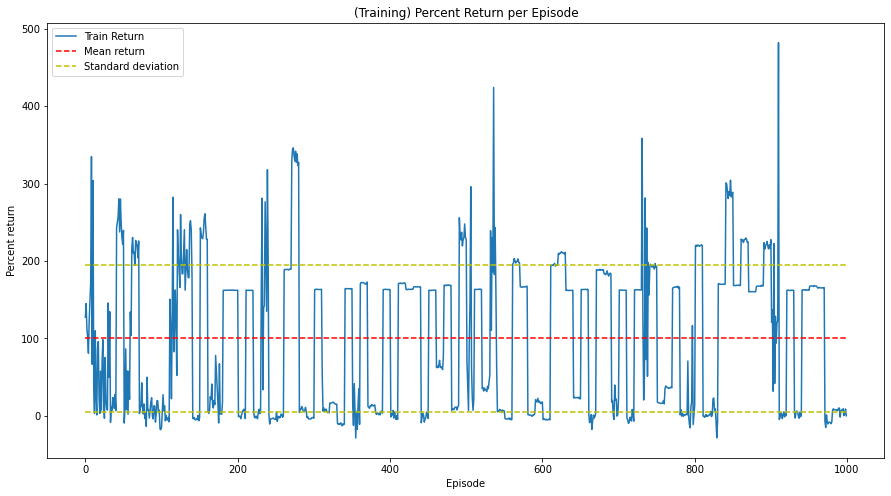

In [72]:
plt.figure(figsize=(15,8))
unzipped = list(zip(*profits_list))
profits = np.array(unzipped[0])
returns = np.array(unzipped[1])
x_data = np.arange(len(profits_list))
plotting = returns[:1000]
plt.plot(plotting)
plt.plot(np.arange(len(plotting)), np.ones(len(plotting))*plotting.mean(), 'r--') 
plt.plot(np.arange(len(plotting)), np.ones(len(plotting))*(plotting.mean()+plotting.std()), 'y--') 
plt.plot(np.arange(len(plotting)), np.ones(len(plotting))*(plotting.mean()-plotting.std()), 'y--') 
plt.legend(["Train Return","Mean return","Standard deviation"])

plt.xlabel("Episode")
plt.ylabel("Percent return")
plt.title("(Training) Percent Return per Episode")
plt.show()

In [14]:
from matplotlib import animation, rc
from IPython.display import HTML
import matplotlib.pyplot as plt
import csv
%matplotlib inline

In [168]:
test_name = "^HSI_2018"
test_data = np.array(getStockDataVec(test_name))
l = len(test_data) - 1

train_name = "^HSI"
train_data = np.array(getStockDataVec(train_name))
l = len(train_data - 1)
x_data = range(l)

In [215]:
df = pd.read_csv('train_progression2.csv', header=None, sep='\n', nrows = 3000)
df = df[0].str.split(',', expand=True).astype(np.float)
df.shape

(3000, 7382)

In [216]:
print(df[:3])

           0             1             2            3            4     \
0  1.598290e+06  1.307455e+06  1.254215e+06     0.992619          NaN   
1  2.568300e+03  2.607100e+03  2.561700e+03  2614.899902  2578.199951   
2  2.540100e+03  2.590800e+03  2.449900e+03  2553.300049  2713.699951   

          5       6            7            8            9     ...  7372  \
0          NaN     NaN          NaN          NaN          NaN  ...   NaN   
1  2484.399902  2524.0  2585.199951  2606.399902  2673.600098  ...   NaN   
2  2694.899902  2739.5  2827.399902  2879.000000  2843.600098  ...   NaN   

   7373  7374  7375  7376  7377  7378  7379  7380  7381  
0   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
1   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  
2   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN  

[3 rows x 7382 columns]


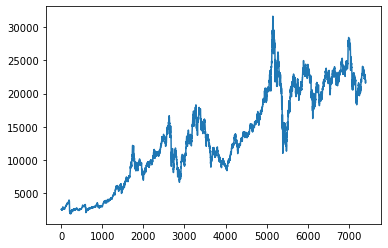

In [217]:
plt.plot(train_data)

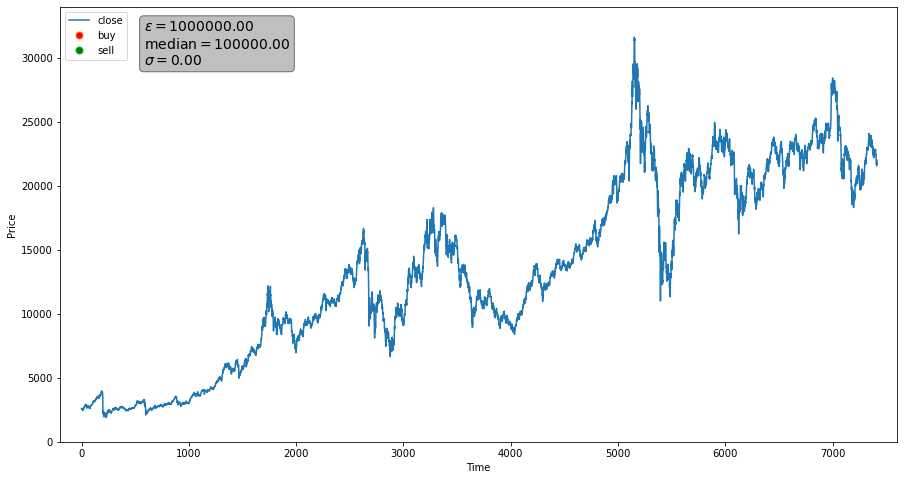

In [272]:
fig, ax = plt.subplots(figsize=(15,8))

# ax.set_xlim(( -15, 515))
# ax.set_ylim((20000, 34000))
ax.set_xlim(( -200, 7600))
ax.set_ylim((0, 34000))



close_plot, = ax.plot(x_data, train_data[:])
buys_plot, = ax.plot([], [], '.',marker='o',markersize=7, markerfacecolor='r')
sells_plot, = ax.plot([],[], '.',marker='o',markersize=7, markerfacecolor='g')

ax.legend(['close', 'buy', 'sell'], loc='upper left')
ax.set_xlabel("Time")
ax.set_ylabel("Price")

textstr = '\n'.join((
    r'$\epsilon=%.2f$' % (1000000, ),
    r'$\mathrm{median}=%.2f$' % (100000, ),
    r'$\sigma=%.2f$' % (0, )))

props = dict(boxstyle='round', facecolor='gray', alpha=0.5)

# place a text box in upper left in axes coords
text = ax.text(0.1, 0.97, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', horizontalalignment='left', bbox=props)


def init():
    buys_plot.set_data([], [])
    sells_plot.set_data([],[])
    return (close_plot, buys_plot,sells_plot, text)

In [275]:
skip = 15
truncate = 1
rows_per = 3
def animate(i):
    i *= skip  # to reduce frames, we skip some
    ax.set_title("Episode " + str(i) + " / " + str(int(df.shape[0] // rows_per // truncate)))
    i *= rows_per
    buys = df[i+1:i+2].to_numpy().flatten()
    lst = []
    for j in range(len(buys)):
        if np.isnan(buys[j]):
            break
        lst.append(np.where(train_data == buys[j])[0][0])
    buys = np.array(lst)
    sells = df[i+2:i+3].to_numpy().flatten()
    lst = []
    for j in range(len(sells)):
        if np.isnan(sells[j]):
            break
        lst.append(np.where(train_data == sells[j])[0][0])
    sells = np.array(lst)
    buys = buys[np.isfinite(buys)].astype(int)
    sells = sells[np.isfinite(sells)].astype(int)
#     sells_plot.set_data(sells,train_data[sells])
#     buys_plot.set_data(buys,train_data[buys])
    
    # first is profit, value held, max_staked, and epsilon; 
    stats = df[i:i+1].to_numpy().flatten().astype(int)
    ret = stats[0] / stats[2] * 100
        
    textstr = '\n'.join((
    r'Profit = %d' % (stats[0], ),
    r'Value held at end = %d' % (stats[1], ),
    r'Max staked = %d' % (stats[2], ),
    r'Percent return = %d' % (ret, )    
    ))
    
    text.set_visible(True)

    # place a text box in upper left in axes coords
    text.set_text(textstr)


    
    return (close_plot, buys_plot,sells_plot, text)
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=int(df.shape[0]/ rows_per / truncate / skip), interval=50, 
                               blit=True)


In [276]:
HTML(anim.to_jshtml())

In [289]:
freq = 3
rows_per_data = 3
profits = []
def shorten_file(old_fname, new_fname):
    # first is profit, value held, max_staked, and epsilon; 
    profit = []
    value_held = []
    max_staked = []
    with open(old_fname, 'r') as inp, open(new_fname, 'w') as out:
        writer = csv.writer(out)
        i = 0
        since = 0
        for row in csv.reader(inp):
            if since > 0 or i % (freq * rows_per_data) == 0:
#                 since += 1
#                 print(row[0], row[1], row[2])
                profit.append(float(row[0]))
                value_held.append(float(row[1]))
                max_staked.append(float(row[2]))
                writer.writerow(row)
                if since == rows_per_data:
                    since = 0
            i += 1
            if i % 500 == 0:
                print(i)
        return np.array(profit),np.array(value_held),np.array(max_staked)


500
[ 3.44608123e+05  1.31390178e+05  8.92812110e+03 -8.99014649e+03
  5.62671445e+04  9.04784551e+04  1.89802037e+05  4.12497109e+04
  5.06249668e+04  7.74664414e+04  3.10697381e+05 -6.50798340e+04
 -6.61927715e+04  1.60477451e+05 -2.27435078e+04 -1.24099150e+05
 -1.07208969e+05 -1.24021863e+05 -7.17121074e+04  1.02264691e+06
  1.23788500e+06  1.75084444e+06  3.48188307e+05  3.03203621e+05
  2.88743209e+05  2.69746836e+05  3.10748287e+05  3.01411258e+05
  5.89824883e+06  2.28169770e+07  4.20874534e+07  6.15272066e+07
  4.12768686e+07  1.96324128e+07  3.43593633e+05  9.20101230e+05
  1.47154022e+06  1.09426064e+06  1.52760895e+05  1.53830488e+05
  1.52420635e+05  1.49957590e+05  7.89366979e+05 -4.36797832e+04
  3.47404199e+05 -1.75795820e+04  1.75154400e+05  6.87436153e+04
  1.12683338e+05  6.73057981e+05  3.05203150e+06  3.31194382e+06
  2.85993736e+05  3.47407498e+05  3.18087490e+05  4.44661209e+05
  8.50995629e+05  6.29800785e+05  4.28319236e+05  4.26261645e+05
  4.23078779e+05  4.2

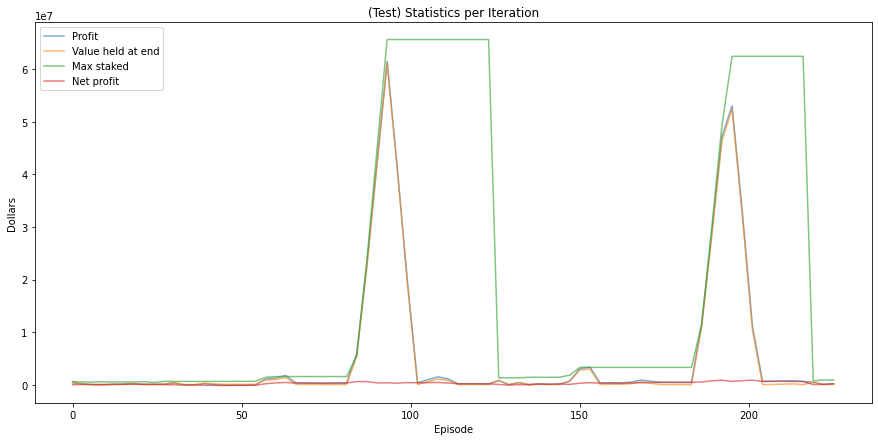

In [290]:
def visualize_prog(s):
    ext_in = "_progression.csv"
    ext_out = "_progression_short.csv"
    profit, value_held, max_staked = shorten_file(s + ext_in,s + ext_out)
    print(profit)
    print(value_held)
    print(max_staked)
    percent_return = (profit - value_held)/max_staked * 100
    print(percent)
#     profit = profit / (10**6)
#     value_held = value_held / (10**6)
#     max_staked = max_staked / (10**6)
    plt.figure(figsize=(15,7))
    x_data = np.arange(len(profit)) * 3
    plt.plot(x_data, profit, alpha=.6)
    plt.plot(x_data, value_held, alpha=.6)
    plt.plot(x_data, max_staked, alpha=.6)
    plt.plot(x_data, profit - value_held, alpha=.6)
    plt.xlabel("Episode")
    plt.ylabel("Dollars")
    if s == "train":
        cap = "(Train)"
    else:
        cap = "(Test)"
    plt.title(cap + " Statistics per Iteration")
    plt.legend(["Profit","Value held at end","Max staked", "Net profit"])
    plt.show()
# visualize_prog("train")
visualize_prog("test")


In [ ]:
# Graphs todo:
# percent return of train vs test
# test statistics (once done)
# redo animation for test
# do animation for train